In [1]:
import warnings
warnings.filterwarnings('ignore')

import scipy

import numpy as np
import matplotlib.pyplot as plt


from scipy.linalg import expm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.svm import SVC
from sklearn import datasets
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
def ad_hoc_data(training_size, test_size, n, gap, PLOT_DATA):
    class_labels = [r'A', r'B']
    if n == 2:
        N = 100
    elif n == 3:
        N = 20   # courseness of data seperation

    label_train = np.zeros(2*(training_size+test_size))
    sample_train = []
    sampleA = [[0 for x in range(n)] for y in range(training_size+test_size)]
    sampleB = [[0 for x in range(n)] for y in range(training_size+test_size)]

    sample_Total = [[[0 for x in range(N)] for y in range(N)] for z in range(N)]

    interactions = np.transpose(np.array([[1, 0], [0, 1], [1, 1]]))

    steps = 2*np.pi/N

    sx = np.array([[0, 1], [1, 0]])
    X = np.asmatrix(sx)
    sy = np.array([[0, -1j], [1j, 0]])
    Y = np.asmatrix(sy)
    sz = np.array([[1, 0], [0, -1]])
    Z = np.asmatrix(sz)
    J = np.array([[1, 0], [0, 1]])
    J = np.asmatrix(J)
    H = np.array([[1, 1], [1, -1]])/np.sqrt(2)
    H2 = np.kron(H, H)
    H3 = np.kron(H, H2)
    H = np.asmatrix(H)
    H2 = np.asmatrix(H2)
    H3 = np.asmatrix(H3)

    f = np.arange(2**n)

    my_array = [[0 for x in range(n)] for y in range(2**n)]

    for arindex in range(len(my_array)):
        temp_f = bin(f[arindex])[2:].zfill(n)
        for findex in range(n):
            my_array[arindex][findex] = int(temp_f[findex])

    my_array = np.asarray(my_array)
    my_array = np.transpose(my_array)

    # Define decision functions
    maj = (-1)**(2*my_array.sum(axis=0) > n)
    parity = (-1)**(my_array.sum(axis=0))
    dict1 = (-1)**(my_array[0])
    if n == 2:
        D = np.diag(parity)
    elif n == 3:
        D = np.diag(maj)

    Basis = np.random.random((2**n, 2**n)) + 1j*np.random.random((2**n, 2**n))
    Basis = np.asmatrix(Basis).getH()*np.asmatrix(Basis)

    [S, U] = np.linalg.eig(Basis)

    idx = S.argsort()[::-1]
    S = S[idx]
    U = U[:, idx]

    M = (np.asmatrix(U)).getH()*np.asmatrix(D)*np.asmatrix(U)

    psi_plus = np.transpose(np.ones(2))/np.sqrt(2)
    psi_0 = 1
    for k in range(n):
        psi_0 = np.kron(np.asmatrix(psi_0), np.asmatrix(psi_plus))

    sample_total_A = []
    sample_total_B = []
    sample_total_void = []
    if n == 2:
        for n1 in range(N):
            for n2 in range(N):
                x1 = steps*n1
                x2 = steps*n2
                phi = x1*np.kron(Z, J) + x2*np.kron(J, Z) + (np.pi-x1)*(np.pi-x2)*np.kron(Z, Z)
                Uu = scipy.linalg.expm(1j*phi)
                psi = np.asmatrix(Uu)*H2*np.asmatrix(Uu)*np.transpose(psi_0)
                temp = np.asscalar(np.real(psi.getH()*M*psi))
                if temp > gap:
                    sample_Total[n1][n2] = +1
                elif temp < -gap:
                    sample_Total[n1][n2] = -1
                else:
                    sample_Total[n1][n2] = 0

        # Now sample randomly from sample_Total a number of times training_size+testing_size
        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            if sample_Total[draw1][draw2] == +1:
                sampleA[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
                tr += 1

        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            if sample_Total[draw1][draw2] == -1:
                sampleB[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
                tr += 1

        sample_train = [sampleA, sampleB]

        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:
            img = plt.imshow(np.asmatrix(sample_Total).T, interpolation='nearest',
                             origin='lower', cmap='copper', extent=[0, 2*np.pi, 0, 2*np.pi])
            plt.show()
            fig2 = plt.figure()
            for k in range(0, 2):
                plt.scatter(sample_train[label_train == k, 0][:training_size],
                            sample_train[label_train == k, 1][:training_size])

            plt.title("Ad-hoc Data")
            plt.show()

    elif n == 3:
        for n1 in range(N):
            for n2 in range(N):
                for n3 in range(N):
                    x1 = steps*n1
                    x2 = steps*n2
                    x3 = steps*n3
                    phi = x1*np.kron(np.kron(Z, J), J) + x2*np.kron(np.kron(J, Z), J) + x3*np.kron(np.kron(J, J), Z) + \
                        (np.pi-x1)*(np.pi-x2)*np.kron(np.kron(Z, Z), J)+(np.pi-x2)*(np.pi-x3)*np.kron(np.kron(J, Z), Z) + \
                        (np.pi-x1)*(np.pi-x3)*np.kron(np.kron(Z, J), Z)
                    Uu = scipy.linalg.expm(1j*phi)
                    psi = np.asmatrix(Uu)*H3*np.asmatrix(Uu)*np.transpose(psi_0)
                    temp = np.asscalar(np.real(psi.getH()*M*psi))
                    if temp > gap:
                        sample_Total[n1][n2][n3] = +1
                        sample_total_A.append([n1, n2, n3])
                    elif temp < -gap:
                        sample_Total[n1][n2][n3] = -1
                        sample_total_B.append([n1, n2, n3])
                    else:
                        sample_Total[n1][n2][n3] = 0
                        sample_total_void.append([n1, n2, n3])

        # Now sample randomly from sample_Total a number of times training_size+testing_size
        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            draw3 = np.random.choice(N)
            if sample_Total[draw1][draw2][draw3] == +1:
                sampleA[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N, 2*np.pi*draw3/N]
                tr += 1

        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            draw3 = np.random.choice(N)
            if sample_Total[draw1][draw2][draw3] == -1:
                sampleB[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N, 2*np.pi*draw3/N]
                tr += 1

        sample_train = [sampleA, sampleB]

        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:

            sample_total_A = np.asarray(sample_total_A)
            sample_total_B = np.asarray(sample_total_B)
            x1 = sample_total_A[:, 0]
            y1 = sample_total_A[:, 1]
            z1 = sample_total_A[:, 2]

            x2 = sample_total_B[:, 0]
            y2 = sample_total_B[:, 1]
            z2 = sample_total_B[:, 2]

            fig1 = plt.figure()
            ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
            ax1.scatter(x1, y1, z1, c='#8A360F')
            plt.show()
        #
            fig2 = plt.figure()
            ax2 = fig2.add_subplot(1, 1, 1, projection='3d')
            ax2.scatter(x2, y2, z2, c='#683FC8')
            plt.show()

            sample_training_A = training_input['A']
            sample_training_B = training_input['B']

            x1 = sample_training_A[:, 0]
            y1 = sample_training_A[:, 1]
            z1 = sample_training_A[:, 2]

            x2 = sample_training_B[:, 0]
            y2 = sample_training_B[:, 1]
            z2 = sample_training_B[:, 2]

            fig1 = plt.figure()
            ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
            ax1.scatter(x1, y1, z1, c='#8A360F')
            ax1.scatter(x2, y2, z2, c='#683FC8')
            plt.show()

    return sample_Total, training_input, test_input, class_labels

In [3]:
def sample_ad_hoc_data(sample_Total, test_size, n):
    tr = 0

    class_labels = [r'A', r'B']  # copied from ad_hoc_data()
    if n == 2:
        N = 100
    elif n == 3:
        N = 20

    label_train = np.zeros(2*test_size)
    sampleA = [[0 for x in range(n)] for y in range(test_size)]
    sampleB = [[0 for x in range(n)] for y in range(test_size)]
    while tr < (test_size):
        draw1 = np.random.choice(N)
        draw2 = np.random.choice(N)
        if sample_Total[draw1][draw2] == +1:
            sampleA[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
            tr += 1

    tr = 0
    while tr < (test_size):
        draw1 = np.random.choice(N)
        draw2 = np.random.choice(N)
        if sample_Total[draw1][draw2] == -1:
            sampleB[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
            tr += 1
    sample_train = [sampleA, sampleB]
    for lindex in range(test_size):
        label_train[lindex] = 0
    for lindex in range(test_size):
        label_train[test_size+lindex] = 1
    label_train = label_train.astype(int)
    sample_train = np.reshape(sample_train, (2 * test_size, n))
    test_input = {key: (sample_train[label_train == k, :])[:] for k, key in enumerate(class_labels)}
    return test_input

In [4]:
def Breast_cancer(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B']
    data, target = datasets.load_breast_cancer(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=0.3, random_state=12)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Breast cancer dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels

In [5]:
def Digits(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B', r'C', r'D', r'E', r'F', r'G', r'H', r'I', r'J']
    data = datasets.load_digits()
    sample_train, sample_test, label_train, label_test = train_test_split(
        data.data, data.target, test_size=0.3, random_state=22)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 9):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Digits dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels

In [6]:
def Iris(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B', r'C']
    data, target = datasets.load_iris(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=1, random_state=42)
    
    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    
    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)
    
    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}
    
    if PLOT_DATA:
        for k in range(0, 3):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("Iris dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels

In [7]:
def Wine(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B', r'C']

    data, target = datasets.load_wine(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=0.1,
                                                                          random_state=7)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)
    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 3):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Wine dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels

In [8]:
def Gaussian(training_size, test_size, n, PLOT_DATA):
    sigma = 1
    if n == 2:
        class_labels = [r'A', r'B']
        label_train = np.zeros(2*(training_size+test_size))
        sample_train = []
        sampleA = [[0 for x in range(n)] for y in range(training_size+test_size)]
        sampleB = [[0 for x in range(n)] for y in range(training_size+test_size)]
        randomized_vector1 = np.random.randint(2, size=n)
        randomized_vector2 = (randomized_vector1+1) % 2
        for tr in range(training_size+test_size):
            for feat in range(n):
                if randomized_vector1[feat] == 0:
                    sampleA[tr][feat] = np.random.normal(-1/2, sigma, None)
                elif randomized_vector1[feat] == 1:
                    sampleA[tr][feat] = np.random.normal(1/2, sigma, None)
                else:
                    print('Nope')

                if randomized_vector2[feat] == 0:
                    sampleB[tr][feat] = np.random.normal(-1/2, sigma, None)
                elif randomized_vector2[feat] == 1:
                    sampleB[tr][feat] = np.random.normal(1/2, sigma, None)
                else:
                    print('Nope')

        sample_train = [sampleA, sampleB]
        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:
            fig1 = plt.figure()
            for k in range(0, 2):
                plt.scatter(sample_train[label_train == k, 0][:training_size],
                            sample_train[label_train == k, 1][:training_size])

            plt.title("Gaussians")
            plt.show()

        return sample_train, training_input, test_input, class_labels
    elif n == 3:
        class_labels = [r'A', r'B', r'C']
        label_train = np.zeros(3*(training_size+test_size))
        sample_train = []
        sampleA = [[0 for x in range(n)] for y in range(training_size+test_size)]
        sampleB = [[0 for x in range(n)] for y in range(training_size+test_size)]
        sampleC = [[0 for x in range(n)] for y in range(training_size+test_size)]
        randomized_vector1 = np.random.randint(3, size=n)
        randomized_vector2 = (randomized_vector1+1) % 3
        randomized_vector3 = (randomized_vector2+1) % 3
        for tr in range(training_size+test_size):
            for feat in range(n):
                if randomized_vector1[feat] == 0:
                    sampleA[tr][feat] = np.random.normal(2*1*np.pi/6, sigma, None)
                elif randomized_vector1[feat] == 1:
                    sampleA[tr][feat] = np.random.normal(2*3*np.pi/6, sigma, None)
                elif randomized_vector1[feat] == 2:
                    sampleA[tr][feat] = np.random.normal(2*5*np.pi/6, sigma, None)
                else:
                    print('Nope')

                if randomized_vector2[feat] == 0:
                    sampleB[tr][feat] = np.random.normal(2*1*np.pi/6, sigma, None)
                elif randomized_vector2[feat] == 1:
                    sampleB[tr][feat] = np.random.normal(2*3*np.pi/6, sigma, None)
                elif randomized_vector2[feat] == 2:
                    sampleB[tr][feat] = np.random.normal(2*5*np.pi/6, sigma, None)
                else:
                    print('Nope')

                if randomized_vector3[feat] == 0:
                    sampleC[tr][feat] = np.random.normal(2*1*np.pi/6, sigma, None)
                elif randomized_vector3[feat] == 1:
                    sampleC[tr][feat] = np.random.normal(2*3*np.pi/6, sigma, None)
                elif randomized_vector3[feat] == 2:
                    sampleC[tr][feat] = np.random.normal(2*5*np.pi/6, sigma, None)
                else:
                    print('Nope')

        sample_train = [sampleA, sampleB, sampleC]
        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+training_size+test_size+lindex] = 2
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (3*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:
            fig1 = plt.figure()
            for k in range(0, 3):
                plt.scatter(sample_train[label_train == k, 0][:training_size],
                            sample_train[label_train == k, 1][:training_size])

            plt.title("Gaussians")
            plt.show()

        return sample_train, training_input, test_input, class_labels
    else:
        print("Gaussian presently only supports 2 or 3 qubits")

In [9]:
def shuffle_and_split(train_data, test_data, categorical_labels, n):
    train, test = [], []
    
    label_enc = LabelEncoder()
    labels = label_enc.fit_transform(categorical_labels)
    
    for idx, c_label in enumerate(categorical_labels):
        for i in range(len(train_data[c_label])):
            train.append(np.append(train_data[c_label][i], int(labels[idx])))
        for i in range(len(test_data[c_label])):
            test.append(np.append(test_data[c_label][i], int(labels[idx])))
    
    np.random.shuffle(train)
    np.random.shuffle(test)
    
    train = np.array(train)
    test = np.array(test)
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test = test[:, :-1], test[:, -1]
    return X_train, X_test, y_train, y_test

In [10]:
def train_and_evaluate(X_train, X_test, y_train, y_test, name):
    kernels = ["linear", "rbf", "poly","sigmoid"]
    print("For {} dataset".format(name))
    for kernel in kernels:
        scores = {}
        svc = SVC(kernel=kernel)
        #gram = np.dot(X_train, X_train.T)
        #svc.fit(gram, y_train)
        svc.fit(X_train, y_train)
        
        y_pred = svc.predict(X_test)
        #y_pred = svc.predict(gram)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted", labels=np.unique(y_pred))
        recall = recall_score(y_test, y_pred, average="weighted", labels=np.unique(y_pred))
        f1 = f1_score(y_test, y_pred, average="weighted", labels=np.unique(y_pred))
        
        scores["accuracy"] = accuracy
        scores["precision"] = precision
        scores["recall"] = recall
        scores["f1"] = f1
        
        print("Kernel: {}".format(kernel))
        print(scores)
        print("\n")

In [11]:
import time
start = time.time()
print ( (time.time() - start))


0.0002980232238769531


## n = 2

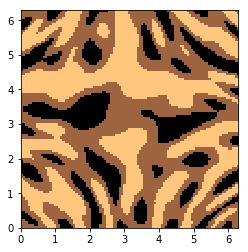

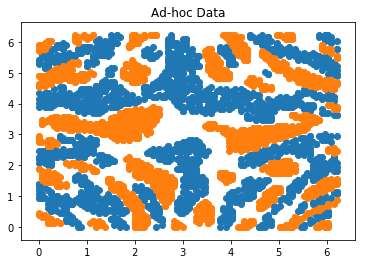

For AD HOC DATA dataset
Kernel: linear
{'accuracy': 0.48, 'precision': 0.4799277398635087, 'recall': 0.48, 'f1': 0.4795315784205785}


Kernel: rbf
{'accuracy': 0.785, 'precision': 0.7915601023017902, 'recall': 0.785, 'f1': 0.7837837837837838}


Kernel: poly
{'accuracy': 0.505, 'precision': 0.5050859525989219, 'recall': 0.505, 'f1': 0.5028997514498758}


Kernel: sigmoid
{'accuracy': 0.55, 'precision': 0.55, 'recall': 0.55, 'f1': 0.55}


49.43751811981201


In [12]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = ad_hoc_data(training_size=2000, test_size=100, n=2, gap=0.3, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=2)
train_and_evaluate(X_train, X_test, y_train, y_test, name="AD HOC DATA")
print ( (time.time() - start))

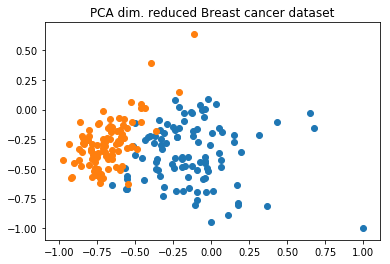

For BREAST CANCER dataset
Kernel: linear
{'accuracy': 0.9, 'precision': 0.9, 'recall': 0.9, 'f1': 0.9}


Kernel: rbf
{'accuracy': 0.95, 'precision': 0.9545454545454545, 'recall': 0.95, 'f1': 0.949874686716792}


Kernel: poly
{'accuracy': 0.9, 'precision': 0.9166666666666667, 'recall': 0.9, 'f1': 0.898989898989899}


Kernel: sigmoid
{'accuracy': 0.9, 'precision': 0.9, 'recall': 0.9, 'f1': 0.9}


0.38935112953186035


In [13]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = Breast_cancer(training_size=100, test_size=10, n=2, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=2)
train_and_evaluate(X_train, X_test, y_train, y_test, name="BREAST CANCER")
print ( (time.time() - start))

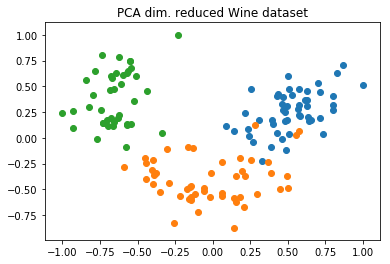

For WINE dataset
Kernel: linear
{'accuracy': 0.875, 'precision': 0.9375, 'recall': 0.875, 'f1': 0.9034090909090908}


Kernel: rbf
{'accuracy': 0.875, 'precision': 0.9375, 'recall': 0.875, 'f1': 0.9034090909090908}


Kernel: poly
{'accuracy': 0.75, 'precision': 0.8214285714285714, 'recall': 0.75, 'f1': 0.7083333333333333}


Kernel: sigmoid
{'accuracy': 0.875, 'precision': 0.9375, 'recall': 0.875, 'f1': 0.9034090909090908}


0.4163968563079834


In [14]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = Wine(training_size=50, test_size=10, n=2, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=2)
train_and_evaluate(X_train, X_test, y_train, y_test, name="WINE")
print ( (time.time() - start))

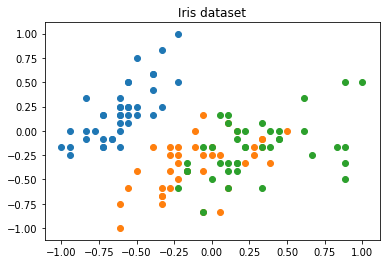

For IRIS dataset
Kernel: linear
{'accuracy': 0.9655172413793104, 'precision': 0.9689655172413794, 'recall': 0.9655172413793104, 'f1': 0.9655172413793104}


Kernel: rbf
{'accuracy': 0.9655172413793104, 'precision': 0.9689655172413794, 'recall': 0.9655172413793104, 'f1': 0.9655172413793104}


Kernel: poly
{'accuracy': 0.6896551724137931, 'precision': 0.8448275862068966, 'recall': 0.6896551724137931, 'f1': 0.6144200626959249}


Kernel: sigmoid
{'accuracy': 0.9655172413793104, 'precision': 0.9689655172413794, 'recall': 0.9655172413793104, 'f1': 0.9655172413793104}


0.339343786239624


In [15]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = Iris(training_size=40, test_size=10, n=2, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=2)
train_and_evaluate(X_train, X_test, y_train, y_test, name="IRIS")
print ( (time.time() - start))

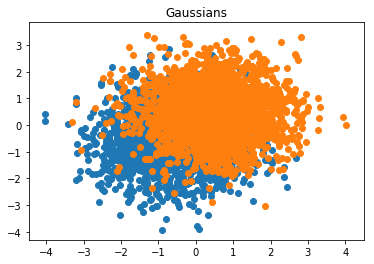

For GAUSSIAN dataset
Kernel: linear
{'accuracy': 0.765, 'precision': 0.7682457738637514, 'recall': 0.765, 'f1': 0.7642869680784372}


Kernel: rbf
{'accuracy': 0.765, 'precision': 0.7682457738637514, 'recall': 0.765, 'f1': 0.7642869680784372}


Kernel: poly
{'accuracy': 0.79, 'precision': 0.792929292929293, 'recall': 0.79, 'f1': 0.7894736842105263}


Kernel: sigmoid
{'accuracy': 0.665, 'precision': 0.6670209535378074, 'recall': 0.665, 'f1': 0.6639835502394743}


2.6319589614868164


In [16]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = Gaussian(training_size=2000, test_size=100, n=2, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=2)
train_and_evaluate(X_train, X_test, y_train, y_test, name="GAUSSIAN")
print ( (time.time() - start))

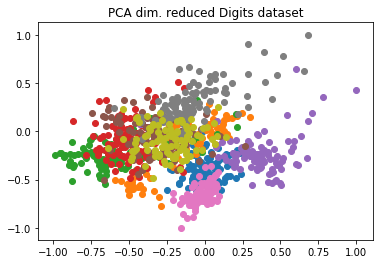

For DIGITS dataset
Kernel: linear
{'accuracy': 0.51, 'precision': 0.48856251591545713, 'recall': 0.51, 'f1': 0.4915885748238689}


Kernel: rbf
{'accuracy': 0.49, 'precision': 0.47830627705627704, 'recall': 0.49, 'f1': 0.4757919857919857}


Kernel: poly
{'accuracy': 0.22, 'precision': 0.4771825396825397, 'recall': 0.275, 'f1': 0.2307826081140285}


Kernel: sigmoid
{'accuracy': 0.5, 'precision': 0.4784559884559884, 'recall': 0.5, 'f1': 0.48049240748931155}


0.8296549320220947


In [17]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = Digits(training_size=100, test_size=10, n=2, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=2)
train_and_evaluate(X_train, X_test, y_train, y_test, name="DIGITS")
print ( (time.time() - start))

## n = 3

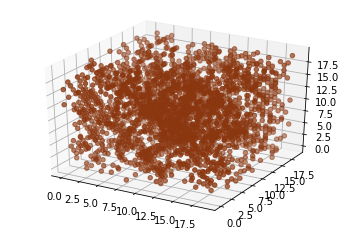

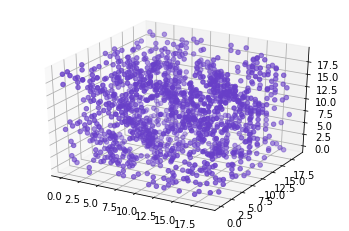

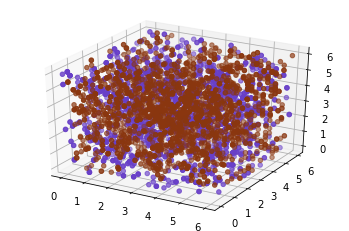

For AD HOC DATA dataset
Kernel: linear
{'accuracy': 0.54, 'precision': 0.5407996736026112, 'recall': 0.54, 'f1': 0.5377349010149733}


Kernel: rbf
{'accuracy': 0.63, 'precision': 0.6302083333333333, 'recall': 0.63, 'f1': 0.6298519407763106}


Kernel: poly
{'accuracy': 0.55, 'precision': 0.5620039682539683, 'recall': 0.55, 'f1': 0.5271122320302648}


Kernel: sigmoid
{'accuracy': 0.51, 'precision': 0.5100040016006403, 'recall': 0.51, 'f1': 0.5099509950995099}


42.44546985626221


In [18]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = ad_hoc_data(training_size=2000, test_size=100, n=3, gap=0.3, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=3)
train_and_evaluate(X_train, X_test, y_train, y_test, name="AD HOC DATA")
print ( (time.time() - start))

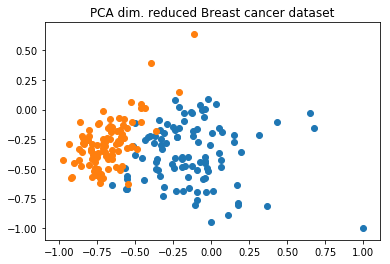

For BREAST CANCER dataset
Kernel: linear
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


Kernel: rbf
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


Kernel: poly
{'accuracy': 0.8, 'precision': 0.8571428571428571, 'recall': 0.8, 'f1': 0.7916666666666666}


Kernel: sigmoid
{'accuracy': 0.95, 'precision': 0.9545454545454545, 'recall': 0.95, 'f1': 0.949874686716792}


0.4172937870025635


In [19]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = Breast_cancer(training_size=100, test_size=10, n=3, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=3)
train_and_evaluate(X_train, X_test, y_train, y_test, name="BREAST CANCER")
print ( (time.time() - start))

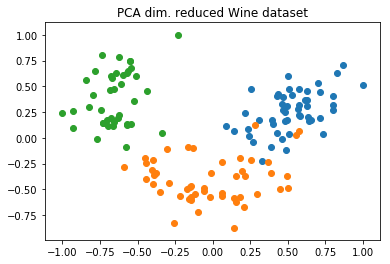

For WINE dataset
Kernel: linear
{'accuracy': 0.8125, 'precision': 0.8863636363636364, 'recall': 0.8125, 'f1': 0.8357142857142859}


Kernel: rbf
{'accuracy': 0.8125, 'precision': 0.8863636363636364, 'recall': 0.8125, 'f1': 0.8357142857142859}


Kernel: poly
{'accuracy': 0.75, 'precision': 0.8214285714285714, 'recall': 0.75, 'f1': 0.7083333333333333}


Kernel: sigmoid
{'accuracy': 0.875, 'precision': 0.9375, 'recall': 0.875, 'f1': 0.9034090909090908}


0.337874174118042


In [20]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = Wine(training_size=50, test_size=10, n=3, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=3)
train_and_evaluate(X_train, X_test, y_train, y_test, name="WINE")
print ( (time.time() - start))

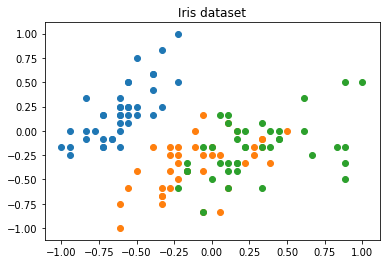

For IRIS dataset
Kernel: linear
{'accuracy': 0.9655172413793104, 'precision': 0.9689655172413794, 'recall': 0.9655172413793104, 'f1': 0.9655172413793104}


Kernel: rbf
{'accuracy': 0.9655172413793104, 'precision': 0.9689655172413794, 'recall': 0.9655172413793104, 'f1': 0.9655172413793104}


Kernel: poly
{'accuracy': 0.6896551724137931, 'precision': 0.8448275862068966, 'recall': 0.6896551724137931, 'f1': 0.6144200626959249}


Kernel: sigmoid
{'accuracy': 0.9655172413793104, 'precision': 0.9689655172413794, 'recall': 0.9655172413793104, 'f1': 0.9655172413793104}


0.35108232498168945


In [21]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = Iris(training_size=40, test_size=10, n=3, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=3)
train_and_evaluate(X_train, X_test, y_train, y_test, name="IRIS")
print ( (time.time() - start))

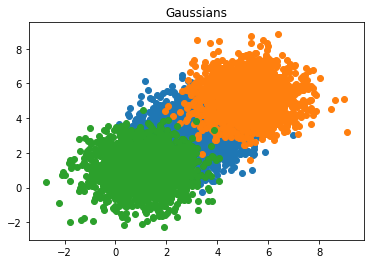

For GAUSSIAN dataset
Kernel: linear
{'accuracy': 0.9566666666666667, 'precision': 0.9569221628045157, 'recall': 0.9566666666666667, 'f1': 0.9567474335373235}


Kernel: rbf
{'accuracy': 0.9566666666666667, 'precision': 0.956927901778267, 'recall': 0.9566666666666667, 'f1': 0.956656914472423}


Kernel: poly
{'accuracy': 0.9566666666666667, 'precision': 0.9568976897689769, 'recall': 0.9566666666666667, 'f1': 0.9567660858188121}


Kernel: sigmoid
{'accuracy': 0.30666666666666664, 'precision': 0.4804469273743016, 'recall': 0.30666666666666664, 'f1': 0.2654655797676066}


4.912895917892456


In [22]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = Gaussian(training_size=2000, test_size=100, n=3, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=3)
train_and_evaluate(X_train, X_test, y_train, y_test, name="GAUSSIAN")
print ( (time.time() - start))

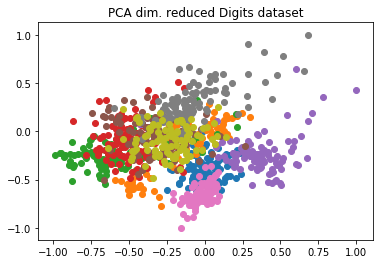

For DIGITS dataset
Kernel: linear
{'accuracy': 0.69, 'precision': 0.6752686202686203, 'recall': 0.69, 'f1': 0.676219922335483}


Kernel: rbf
{'accuracy': 0.71, 'precision': 0.7026495726495727, 'recall': 0.71, 'f1': 0.6939227195382801}


Kernel: poly
{'accuracy': 0.2, 'precision': 0.7232142857142857, 'recall': 0.25, 'f1': 0.235511828596935}


Kernel: sigmoid
{'accuracy': 0.69, 'precision': 0.6765564990564991, 'recall': 0.69, 'f1': 0.6762366307732439}


0.8340821266174316


In [23]:
import time
start = time.time()
_, train_data, test_data, categorical_labels = Digits(training_size=100, test_size=10, n=3, PLOT_DATA=True)
X_train, X_test, y_train, y_test = shuffle_and_split(train_data, test_data, categorical_labels, n=3)
train_and_evaluate(X_train, X_test, y_train, y_test, name="DIGITS")
print ( (time.time() - start))